> Aprenentatge Computacional

**Nom**: Gabriel Rios Sanchez\
**NIU**: 1671177

# SUPERMARKET SALES

---

In [1271]:
# LLIBRERIA PER MANIPULACIÓ DE DADES
import pandas as pd

# LLIBRERIA PER TREBALLAR AMB MATRIUS MULTIDIMENSIONALS
import numpy as np

# LLIBRERIA PER DETECTAR VALORS NULS
import missingno as msno

# LLIBRERIA PER VISUALITZAR DADES
import seaborn as sns
import matplotlib.pylab as plt

# LLIBRERIA PER DIVIDIR EL CONJUNT D'ENTRENAMENT I PROVA
from sklearn.model_selection import train_test_split

# LLIBRERIES PER TRANSFORMAR VARIABLES CATEGÒRIQUES A FORMATS NUMÈRICS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# LLIBRERIA PER EINES DE PREPROCESSING
from sklearn.preprocessing import StandardScaler

# LLIBRERIA PER IMPORTAR DIFERENTS MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# LLIBRERIA PER ANALITZAR DIFERENTS MODELS
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score

# LLIBRERIA PER FER VALIDACIÓ DE DIFERENTS MODELS
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, GridSearchCV, cross_val_predict

# LLIBRERIA PER CREAR CÒPIES D'OBJECTES
import copy as cp

import warnings
warnings.filterwarnings('ignore')

## 0. ENUNCIAT INICIAL

L’objectiu és predir la sucursal (Branch) on es realitzen les vendes per optimitzar la gestió dels inventaris en cada ubicació. Per aconseguir-ho, es desenvoluparan diferents models de predicció que permetin estimar la variable objectiu amb la màxima precisió possible.

In [1272]:
dataset = pd.read_csv("dataset/data.csv")
dataset.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


---

## 1. ANÀLISI DE DADES

In [1273]:
print("El dataset conté:", dataset.shape[0], "mostres i", dataset.shape[1], "atributs.")

El dataset conté: 1000 mostres i 17 atributs.


Per començar, s’executarà la funció `identifyCategoricalFeatures` per identificar les variables categòriques de manera ràpida. Aquesta funció analitza la proporció de valors únics d’un atribut i, en funció d’un llindar definit com a paràmetre d’entrada, decideix si un atribut numèric s’ha de considerar categòric o no. Posteriorment, es descriurà el significat de cada atribut i s’analitzarà la distribució dels seus valors.

In [1274]:
def identifyCategoricalFeatures(data, threshold=0.05):
    categoricalCols = data.select_dtypes(include='object').columns.tolist()
    numericalCols = data.select_dtypes(include='number')
    uniqueProp = numericalCols.nunique() / len(data)
    categoricalCols += uniqueProp[uniqueProp < threshold].index.tolist()
    return categoricalCols

atributsCategoricsIdentify = identifyCategoricalFeatures(dataset)
print("Atributs categòrics: ", atributsCategoricsIdentify)

Atributs categòrics:  ['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Date', 'Time', 'Payment', 'Quantity', 'gross margin percentage']


In [1275]:
descripcio = pd.DataFrame({
    "Nom de la columna": dataset.columns,
    "Tipus de dades reals": ["Categòric" if str(dtype) == "object" else "Numèric" for dtype in dataset.dtypes],
    "Tipus de dades trobades": ["Categòric" if col in atributsCategoricsIdentify else "Numèric" for col in dataset.columns]
})
descripcio

,Nom de la columna,Tipus de dades reals,Tipus de dades trobades
0,Invoice ID,Categòric,Categòric
1,Branch,Categòric,Categòric
2,City,Categòric,Categòric
3,Customer type,Categòric,Categòric
4,Gender,Categòric,Categòric
5,Product line,Categòric,Categòric
6,Unit price,Numèric,Numèric
7,Quantity,Numèric,Categòric
8,Tax 5%,Numèric,Numèric
9,Total,Numèric,Numèric


A la anterior taula podem veure informació sobre cada atribut. La primera columna es el nom, la segona es el seu tipus de dades reals, es a dir, si al dataset es numeric o no. En canvi, a la tercera columna es mostren els resultats que ha tret la funció `identifyCategoricalFeatures`. Aquesta última columna ens permet identificar si un atribut numèric és en realitat categòric. Això és important d’identificar correctament, ja que afecta directament com es processen i s’analitzen les dades.

Com a resultat d'analitzar la taula, veiem que la funció `identifyCategoricalFeatures` ha identificat dos atributs numèrics com a categòrics. Aquest atributs son: **Quantity** i **gross margin percentage**. Després de la descripció, analitzarem la naturalesa d’aquestes dades per entendre per què la funció les ha identificat com a categòriques.

A continuació, es farà una descripció de cada atribut per analitzar el significat de cadascun.
- **Invoice ID (categòric)**: Identificador únic per a cada transacció realitzada al supermercat. No es tindrà en compte, ja que és únic per cada mostra.
- **Branch (categòric)**: Atribut objectiu que representa la sucursal de supermercat on s’ha efectuat la venda (A, B o C).
- **City (categòric)**: La ciutat on es troba la sucursal associada a la venda. (Yangon, Naypyitaw o Mandalay).
- **Customer type (categòric)**: Indica si el client és un membre o no del supermercat (Member o Normal).
- **Gender (categòric)**: Gènere del client que ha realitzat la compra (Male o Female).
- **Product line (categòric)**: La categoria del producte comprat (Health and Beauty, Electronic Accessories, Home and lifestyle, Sports and travel, Food and beverages o Fashion accessories).
- **Unit price (numèric)**: Preu unitari del producte comprat.
- **Quantity (numèric)**: Quantitat de productes comprats en una sola transacció.
- **Tax 5% (numèric)**: Import corresponent a l’impost aplicat (5%) sobre la transacció.
- **Total (numèric)**: Import total de la factura, incloent-hi l’impost (Tax 5%).
- **Date (categòric)**: Data en què es va realitzar la transacció.
- **Time (categòric)**: Hora en què es va fer la transacció.
- **Payment (categòric)**: Mètode de pagament utilitzat pel client (Ewallet, Cash o Credit Card).
- **cogs (numèric)**: Representa el cost dels productes venuts, abans d’impostos o beneficis.
- **gross margin percentage (numèric)**: Percentatge de marge brut.
- **gross income (numèric)**: Benefici brut obtingut per la venda.
- **Rating (numèric)**: Valoració del client sobre el servei del supermercat, en una escala de 0 a 10.

Com s’ha comentat abans, es farà un anàlisi més a fons de cada atribut. Primer començarem amb els atributs numèrics, ja que sovint tenen una major influència en les prediccions dels models, especialment en aquells que treballen amb valors continus. Ens centrarem especialment en els atributs **Quantity** i **gross margin percentage**, pel fet que la funció anterior els ha identificat com a categòrics.

A continuació, es mostren les estadístiques bàsiques dels atributs numèrics del conjunt de dades mitjançant la funció describe. Aquest resum inclou la mitjana (mean), la desviació estàndard (std), i els valors mínims i màxims, entre d’altres.

Després d’aquest anàlisi, continuarem amb els atributs categòrics, fent un anàlisi de la seva distribució i interpretació.

In [1276]:
dataset.describe()

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,0.000000,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905,49.650000,10.00000


Podem veure a la taula anterior que els camps com **Unit price**, **Total** i **cogs** tenen una alta variació, cosa que pot ser útil per explicar patrons en les dades. En canvi, **gross margin percentage** és constant (valor únic) i no aportarà informació útil als models. Aquest va ser el motiu pel qual la funció va detectar aquest atribut com a categòric, per tant, al no aportar informació s'eliminarà de tot el conjunt de dades.

En quant a l'atribut **Quantity**, podem veure que té un comportament categòric, com ja va detectar la funció `identifyCategoricalFeatures`, ja que conté un rang limitat de valors únics.

A més, gràcies a aquesta taula, podem identificar si algun atribut conté *outliers*, cosa que en aquest cas no passa, ja que les seves desviacions estan dins del rang esperat. Les estadístiques també mostren que les distribucions dels atributs són relativament equilibrades, sense biaix cap a valors extrems. Això valida la coherència de les dades, especialment en atributs com **Total**, **Tax 5%**, **cogs** i **gross income**, que segons la descripció anterior tenen una alta relació entre ells.

Un altre punt rellevant és que els atributs **Tax 5%** i **gross income** presenten exactament les mateixes estadístiques. Això indica que aquestes dues variables tenen distribucions idèntiques i estan fortament relacionades. Gràcies a aquesta descripció, podem entendre millor com és la relació que tenen amb altres atributs relacionats amb el cost de la compra, com **Total** i **cogs**. Aquest grup de característiques s'analitzarà més a fons per veure visualment com és la seva distribució i entendre quina és la seva relació.

A continuació, es veurà la matriu de correlacions de les variables numèriques per identificar la relació entre elles, i així poder entendre millor com interactuen les diferents variables i com poden influir en els resultats de la predicció dels models.

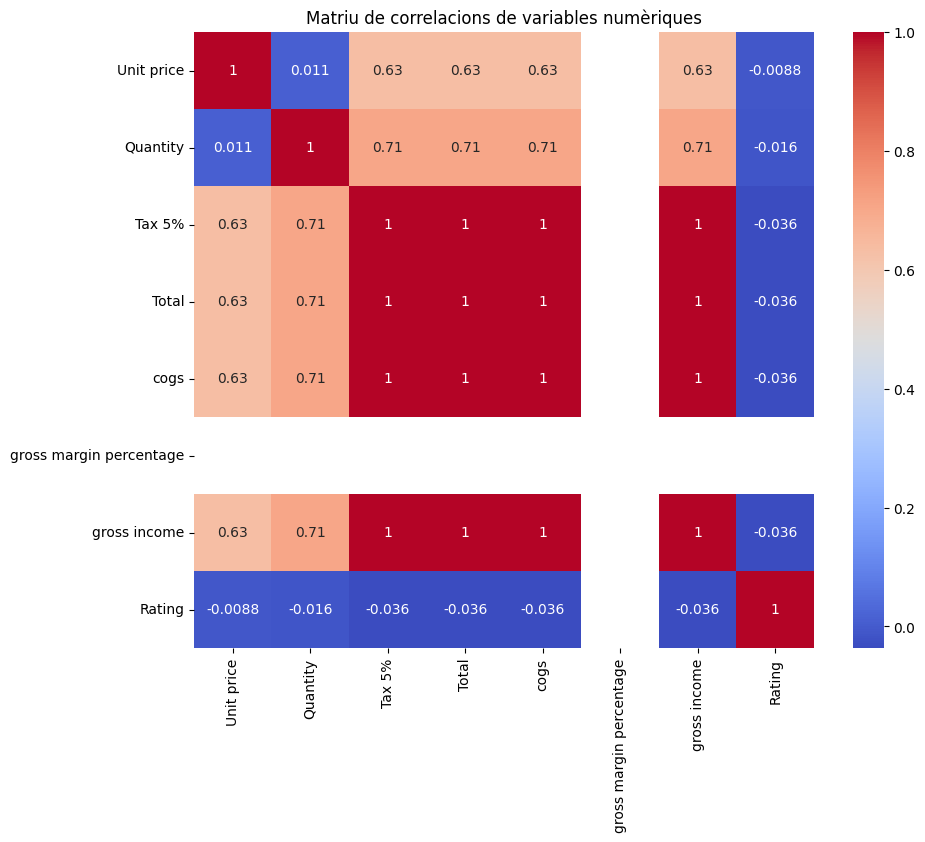

In [1277]:
atributsNumerics = dataset.select_dtypes(["float64", "int64"])
correlacioNumerics = atributsNumerics.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlacioNumerics, annot=True, cmap='coolwarm')
plt.title("Matriu de correlacions de variables numèriques")
plt.show()

A l'anterior matriu de correlacions podem observar que l’atribut **gross margin percentage** no té cap influència sobre cap altre atribut del conjunt de dades. Per aquest motiu, s'eliminarà l'atribut **gross margin percentage**, ja que al tenir un valor únic, no aportarà cap informació al model. A més, es confirma que els atributs **Tax 5%**, **Total**, **cogs** i **gross income** estan directament relacionades (correlació amb 1), ja que segueixen una relació lògica a la seva descripció. Aquestes observacions es tindran en compte durant la selecció d’atributs per al model que es construirà.

In [1278]:
print("Valors únics a gross margin percentage:", dataset["gross margin percentage"].unique())
dataset = dataset.drop("gross margin percentage", axis=1)

Valors únics a gross margin percentage: [4.76190476]


Com ja s’ha comentat abans, analitzarem la distribució de cada variable numèrica relacionada amb el cost per comprendre millor com i per què aquestes estan fortament relacionades, tal com s’ha observat a la matriu de correlacions.

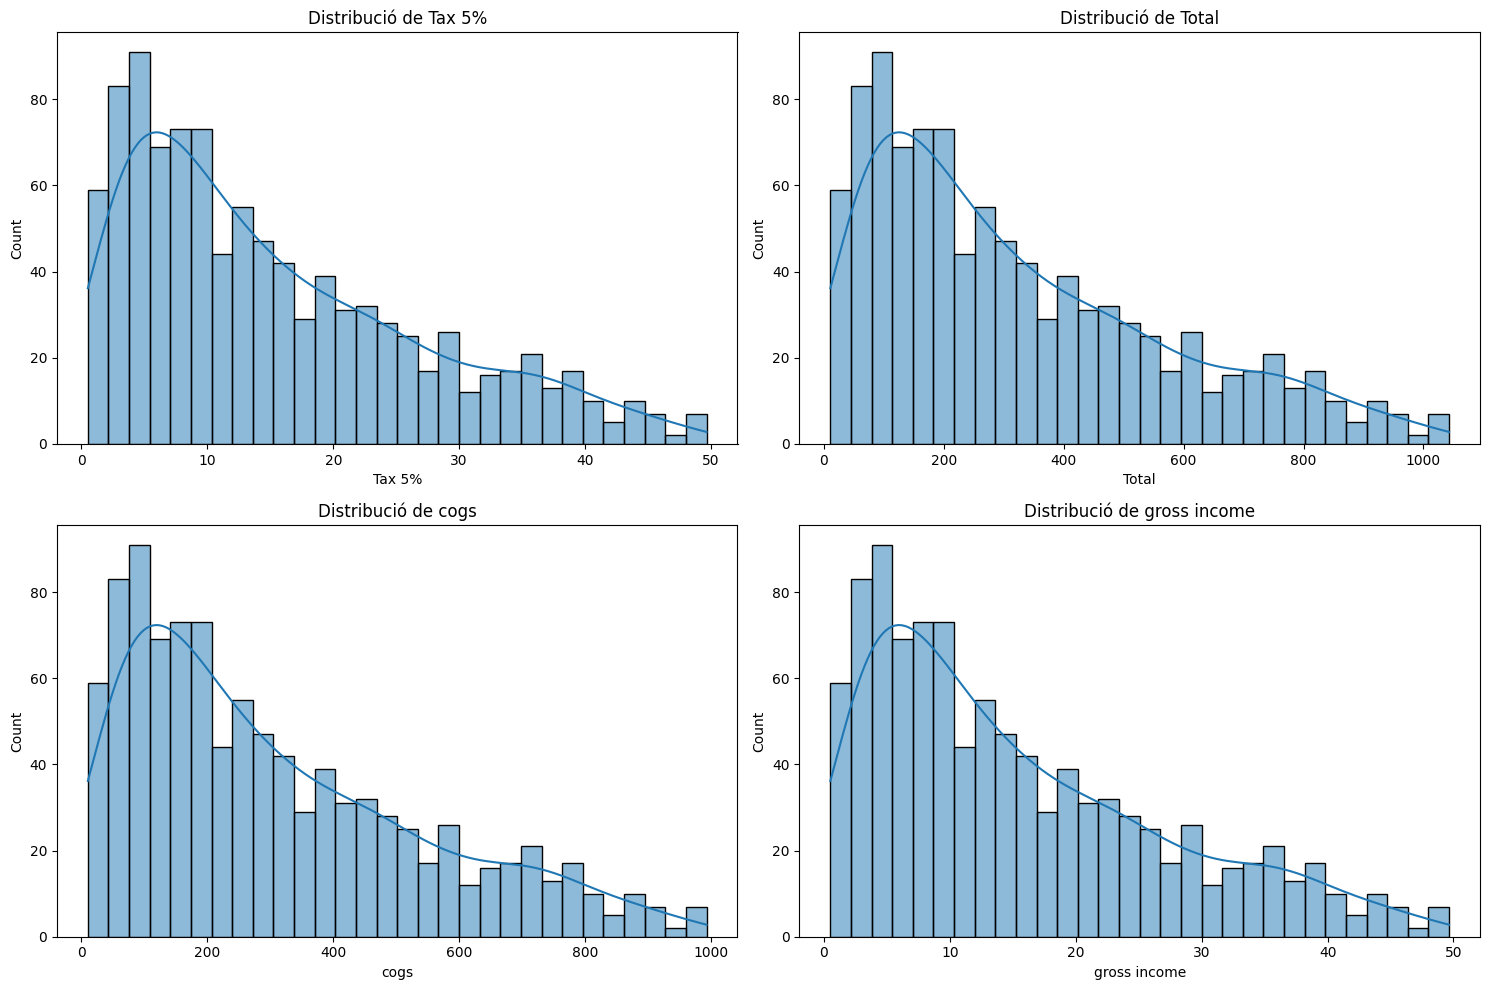

In [1279]:
atributsNumericsCost = ["Tax 5%", "Total", "cogs", "gross income"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(atributsNumericsCost):
    sns.histplot(data=dataset, x=col, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribució de {col}")
    axes[i].set_xlabel(col)
plt.tight_layout()
plt.show()

Com a observació general, podem veure que les distribucions dels atributs **Tax 5%**, **Total**, **cogs** i **gross income** són molt similars, creant un patró que és consistent segons la descripció del conjunt de dades. A més, es pot veure que la majoria de les vendes que es fan són transaccions amb valors baixos i poques amb valors alts.

Pel que fa a la relació entre aquestes variables, s'ha analitzat que en ser tan idèntiques la seva distribució tenen una relació matemàtica, és a dir, han sigut calculades a partir de les altres:
$$ Total = cogs + Tax 5% $$
$$ gross income = Total - cogs $$

En conseqüència, aquestes variables, en ser tan relacionades entre si poden aportar informació redundant al model, augmentant innecessàriament la dimensionalitat. Com a resultat d'aquesta observació, s'eliminarà **cogs**, **Tax 5%** i **gross income**, deixant a **Total** al dataset ja que engloba la informació de totes aquestes variables.

In [1280]:
dataset = dataset.drop("Tax 5%", axis=1)
dataset = dataset.drop("cogs", axis=1)
dataset = dataset.drop("gross income", axis=1)

Per concloure l'anàlisi numèric compararem la correlació que tenen aquests atributs amb la variable objectiu (target) **Branch**. En aquest cas, com el target no és numèric, es farà un encoding simple per poder fer l'anàlisi de correlació.

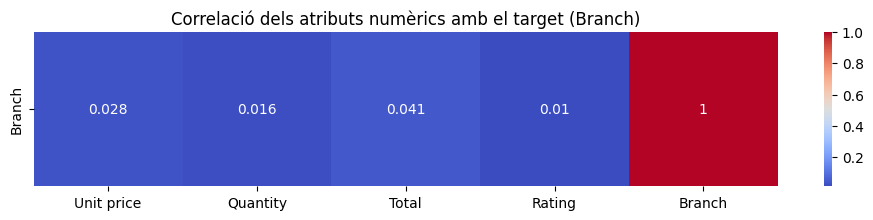

In [1281]:
atributsNumerics = dataset.select_dtypes(["float64", "int64"])
atributsNumerics["Branch"] = dataset["Branch"].astype("category").cat.codes
correlacioNumericsTarget = atributsNumerics.corr().loc["Branch"].to_frame()
plt.figure(figsize=(12, 2))
sns.heatmap(correlacioNumericsTarget.T, annot=True, cmap="coolwarm")
plt.title("Correlació dels atributs numèrics amb el target (Branch)")
plt.show()

Aquest gràfic confirma que les variables numèriques analitzades tenen una correlació molt baixa amb **Branch** (totes per sota de 0.05). Per tant, podrien no ser els millors predictors per aquest atribut. Això es tindrà en compte de cara a la selecció d'atributs, ja que incloure variables amb baixa correlació pot augmentar la dimensionalitat sense aportar valor significatiu al model.

En aquesta secció, s'analitza la distribució de les variables categòriques presents al conjunt de dades. Aquest tipus d'anàlisi és essencial per comprendre la composició de les dades i identificar possibles desequilibris que podrien influir en els resultats finals. Les variables categòriques seleccionades són: **Branch**, **City**, **Customer type**, **Gender**, **Product line** i **Payment**. S'ha exclòs els atributs categòrics **Date** i **Time**, ja que posteriorment es farà una anàlisi temporal d'aquestes variables.

Com a primer pas, eliminarem l'atribut **Invoice ID**, ja que conté un identificador únic per cada mostra i no aporta cap informació rellevant al model, només augmenta la dimensionalitat.

In [1282]:
dataset = dataset.drop("Invoice ID", axis=1)

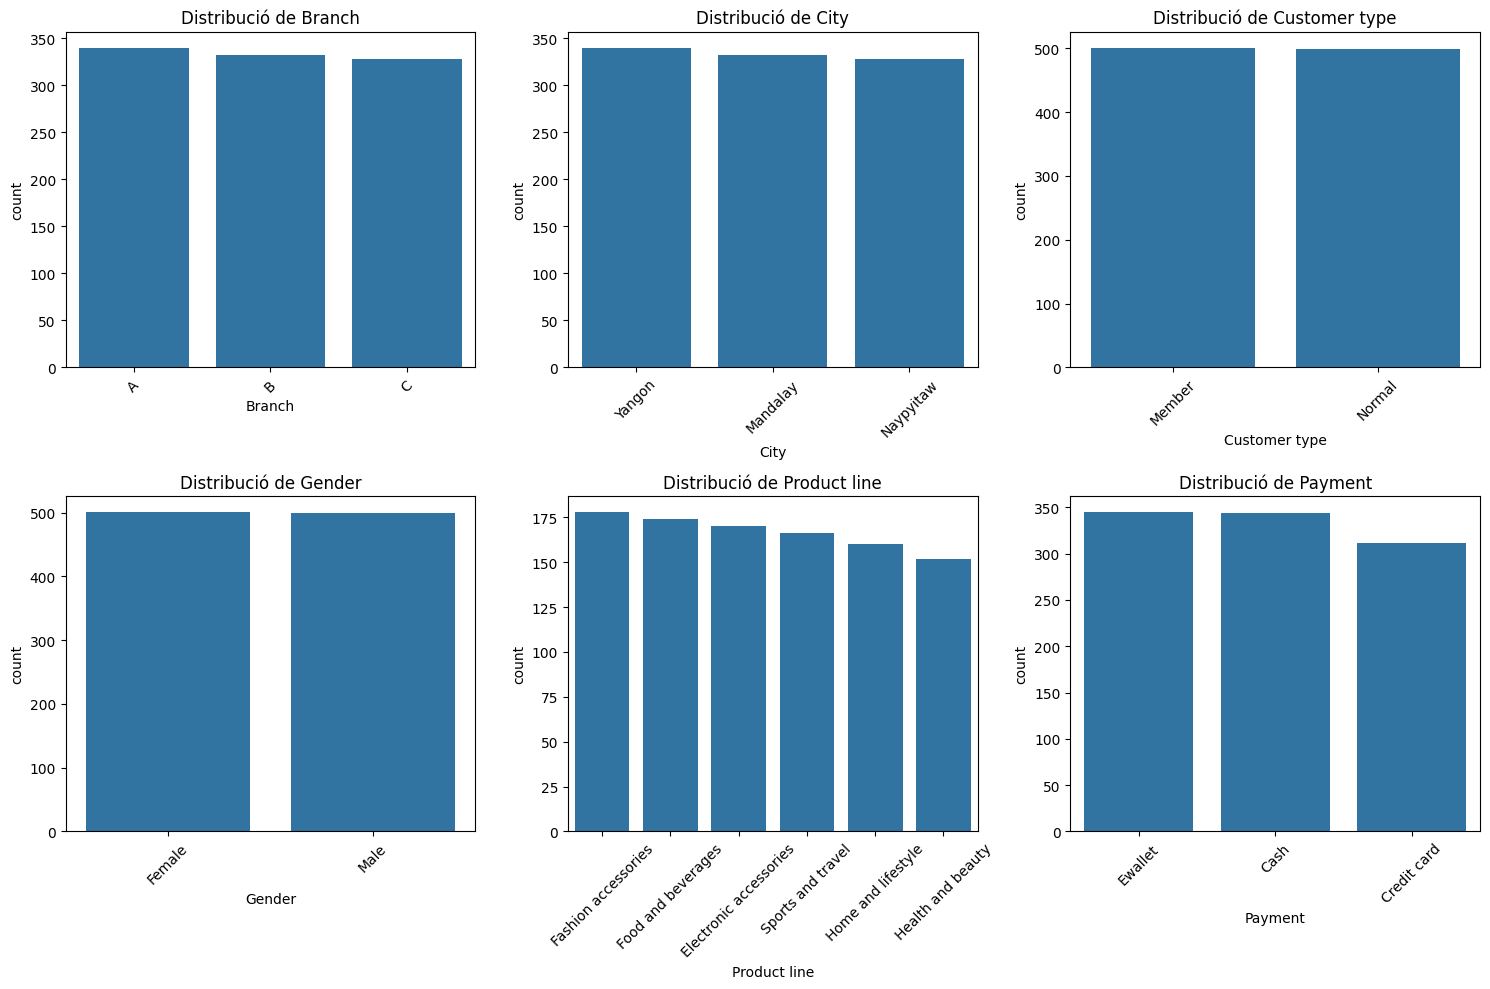

In [1283]:
atributsCategorics = ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(atributsCategorics):
    sns.countplot(data=dataset, x=col, order=dataset[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"Distribució de {col}")
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Amb aquests resultats podem veure que les distribucions dels atributs **Branch**, **City**, **Customer type** i **Gender** tenen unes distribucions força equilibrades. En particular, la informació de la distribució del target **Branch** serà important per a més endavant seleccionar la millor mètrica per mesurar que tan de bé funciona el model.

Pel que fa els altres atributs, **Product line** i **Payment**, podem veure que la distribució té una variabilitat més notable respecte als anteriors atributs categòrics mencionats anteriorment. Això pot ser un indicatiu de què podrien proporcionar informació valuosa per tal de fer un bon model predictiu.

Ara anem a veure com es comporta cada atribut categòric respecte amb el target per analitzar possibles patrons potencials.

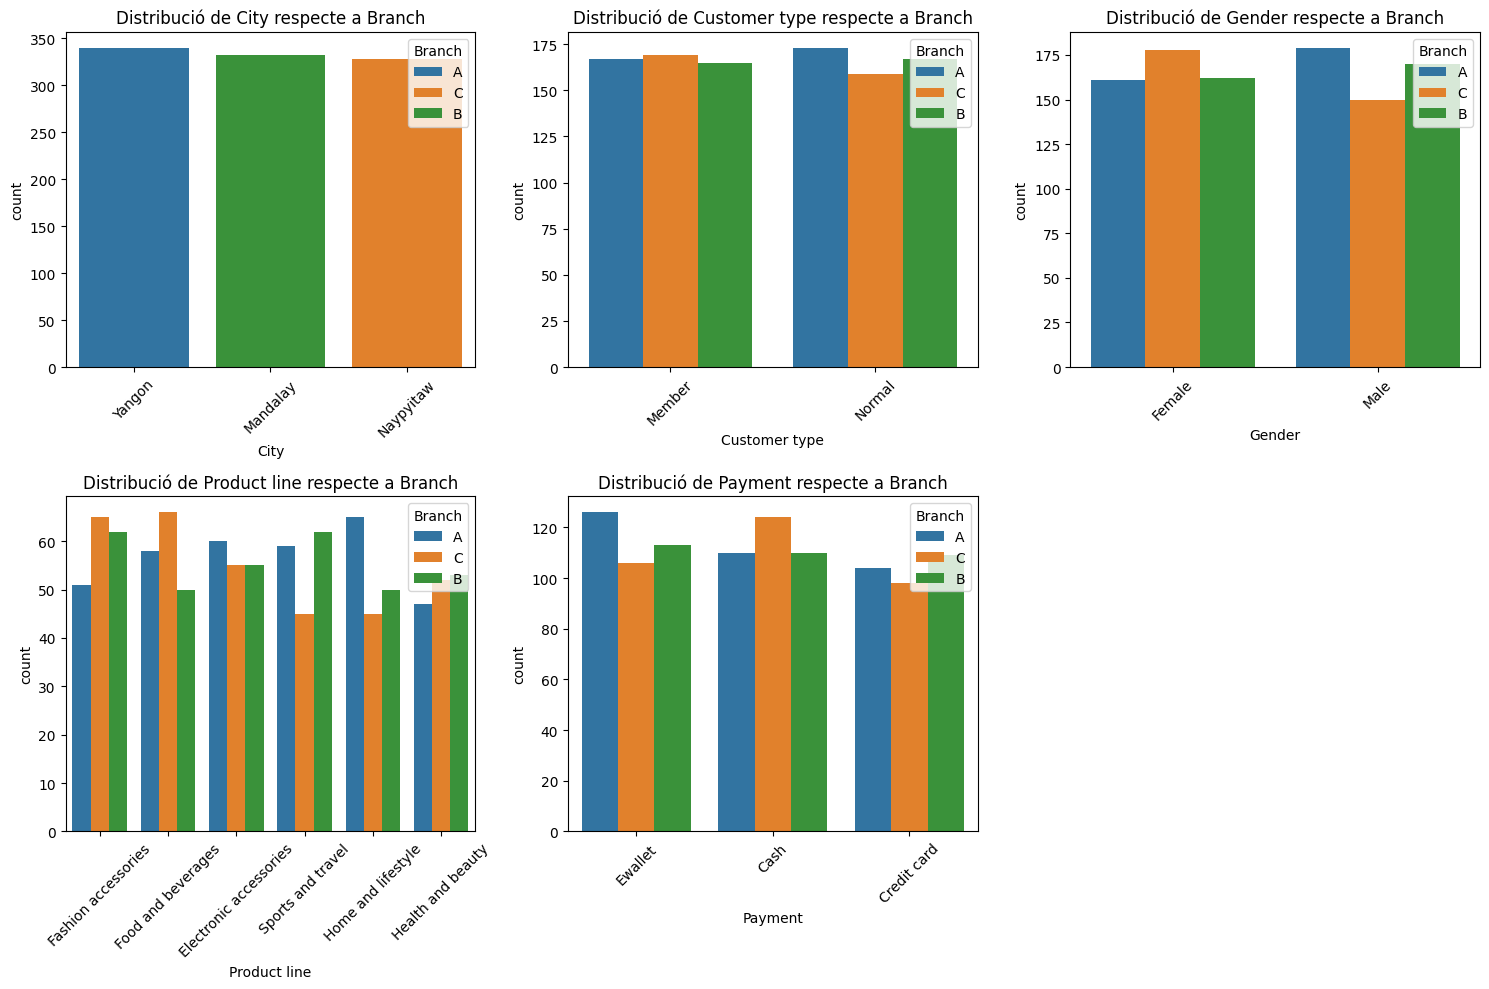

In [1284]:
atributsCategorics = ['City', 'Customer type', 'Gender', 'Product line', 'Payment']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(atributsCategorics):
    sns.countplot(data=dataset, x=col, hue="Branch", order=dataset[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"Distribució de {col} respecte a Branch")
    axes[i].tick_params(axis='x', rotation=45)
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

Per part de la primera gràfica, distribució de City-Branch, podem veure que cadascuna de les ciutats té associada directament a una sucursal (A -> Yangon, B -> Mandalay, C -> Naypyitaw). Aquest és un indicatiu de què l'atribut **City** és un fort predictor del target.

Pel que fa a la segona, distribució Customer type-Branch, podem veure una distribució força equilibrada per totes les sucursals. On hi ha una diferència superior és a la tercera gràfica, distribució Gender-Branch, on podem veure que el nombre d'homes a la sucursal A és significativament major respecte a les dones. Passa el mateix a la sucursal C, però en aquest cas el nombre de dones és superior al dels homes. Pel cas de la sucursal B, trobem una distribució més equilibrada on continua on cap dels dos gèneres té una diferència significativa.

En el cas de la quarta gràfica, distribució Product line-Branch, trobem que per la sucursal A els productes més comprats pels consumidors han sigut de "Home and lifestyle", junt amb "Food and beverages" i "Electronic accessories", mentre que a la sucursal C trobem que els productes més comprats han sigut "Fashion accessories" i "Food and beverages". Pel cas de la sucursal B, trobem que els productes més venuts han sigut "Fashion accesories" i "Sports and travel".

A l'última gràfica, distribució Payment-Branch, podem veure que per la sucursal A sembla que els consumidors prefereixen pagar amb Ewallet, respecte als altres mètodes. Per la part de la sucursal B, podem veure que no hi ha cap tendència respecte a escollir el mètode de pagament, té una distribució força equilibrada. Finalment, per part de la sucursal C, es pot analitzar que la majoria de les persones tendeixen a pagar en efectiu (Cash) respecte als altres dos mètodes.

Com a conclusió d'aquest anàlisi d'atributs categòrics trobem que l'atribut **City** és un predictor directe del target. A més, els atributs **Gender**, **Product line** i **Payment** aporten informació útil per diferenciar les sucursals. Com a últim atribut, **Customer type**, trobem que té una influència menor, ja que la seva distribució es força equilibrada entre les tres sucursals.

Com a penùltim apartat és farà l'anàlisi de les variables temporals, que son: **Date** i **Time**. Aquest anàlisi és essencial per identificar patrons temporals que puguin influir en les vendes.

Per a l’atribut **Date**, s’analitzaran les vendes agrupades per mesos i dies de la setmana per veure si hi ha una variació significativa en les transaccions segons la data. A més, es farà una comparació entre sucursals (**Branch**) per determinar si hi ha diferències notables.

Per a l’atribut **Time**, es farà un anàlisi horari per veure quins són els moments del dia amb més activitat, identificant si aquests patrons varien segons la sucursal.

Abans de començar amb l'atribut **Date**, anem a veure la seva distribució respecte als anys.

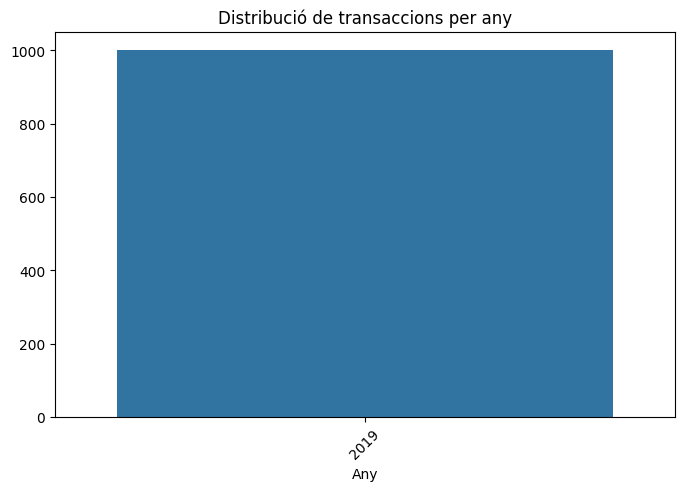

In [1285]:
dataset["Date"] = pd.to_datetime(dataset["Date"])

transacciones_per_year = dataset["Date"].dt.year.value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=transacciones_per_year.index, y=transacciones_per_year.values)
plt.title("Distribució de transaccions per any")
plt.xlabel("Any")
plt.xticks(rotation=45)
plt.show()

Amb l'anterior gràfica podem veure que no aporta cap informació al model, ja que totes les mostres del dataset només corresponen a un any en concret, el 2019. Ara es farà l'anàlisi de l'atribut **Date** respecte al target per veure quina es la seva possible influència com atribut per un model d'aprenentatge.

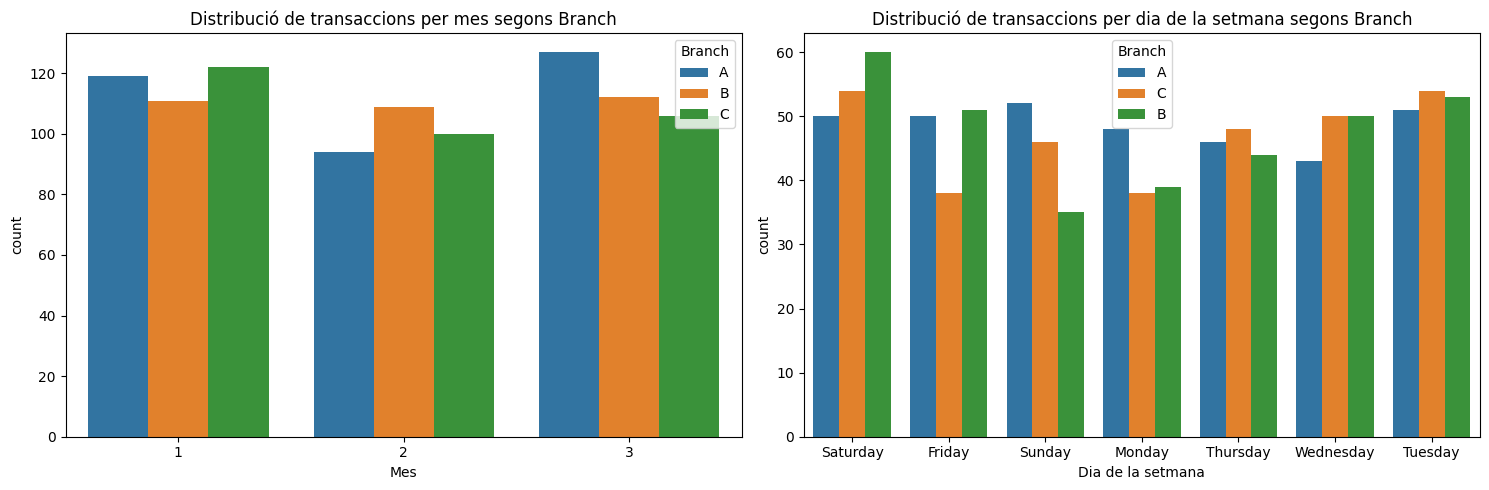

In [1286]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data=dataset, x=dataset["Date"].dt.month, hue="Branch", ax=axes[0])
axes[0].set_title("Distribució de transaccions per mes segons Branch")
axes[0].set_xlabel("Mes")
axes[0].legend(title="Branch")
sns.countplot(data=dataset, x=dataset["Date"].dt.day_name(), hue="Branch", ax=axes[1])
axes[1].set_title("Distribució de transaccions per dia de la setmana segons Branch")
axes[1].set_xlabel("Dia de la setmana")
axes[1].legend(title="Branch")
plt.tight_layout()
plt.show()

Com a primera observació de la gràfica a l'esquerra, podem veure que el dataset conté compres que són dels tres primers mesos de l'any (Gener, Febrer i Març). A més, podem observar variacions lleus a tots els mesos, destacant al Març que la sucursal A obté una diferència notable de transaccions respecte a les altres sucursals (B i C). Com és el mateix cas pel Febrer, que trobem que la sucursal B conté més transacciones, però tenint una activitat més baixa durant el Gener. Respecte al primer mes, Gener, trobem una distribució molt més equilibrada entre la sucursal A i C respecte als altres dos mesos.

A l'altra gràfica situada a la dreta, podem veure com és la distribució de les transaccions respecte als dies de la setmana. Com a observació inicial trobem uns patrons interessants als dies: Saturday, Friday, Sunday i Monday, destacant un desbalanceig notable cap a una o dues sucursals. Pel cas del Saturday trobem que la sucursal B és la que ha fet més transaccions, quedant-se endarrere la sucursal A. Això mateix passa amb el Sunday, però trobem el cas contrari on la sucursal A té més transaccions que la sucursal B que està a la cua de totes. Aquest patró també ho trobem al Monday on es situa la sucursal A com la que més fa transaccions, però al Friday podem veure un equilibri entre les sucursals A i B. Mentre que els altres dies de la setmana trobem un patró més uniforme amb menys desbalanceig, però amb la diferència de què B té molta més influència que els dies concrets mencionats anteriorment.

Després de fer aquest anàlisi de l'atribut **Date**, podem extreure informació adicional per ajudar al model a fer una millor predicció creant dos nous atributs. Aquests son: **Month** i **DayOfWeek**, representant a les dues gràfiques analitzades anteriorment. Pel que fa l'atribut **Date**, s'eliminarà ja que al crear aquests dos nous atributs s’està encapsulant tota la informació temporal rellevant per al model.

In [1287]:
dataset["Month"] = dataset["Date"].dt.month
dataset["DayOfWeek"] = dataset["Date"].dt.day_name()
dataset = dataset.drop("Date", axis=1)

A continuació, és farà l’anàlisi de la distribució d’hores on es fan les transaccions per entendre si existeixen patrons temporals que puguin influir en el comportament de les sucursals.

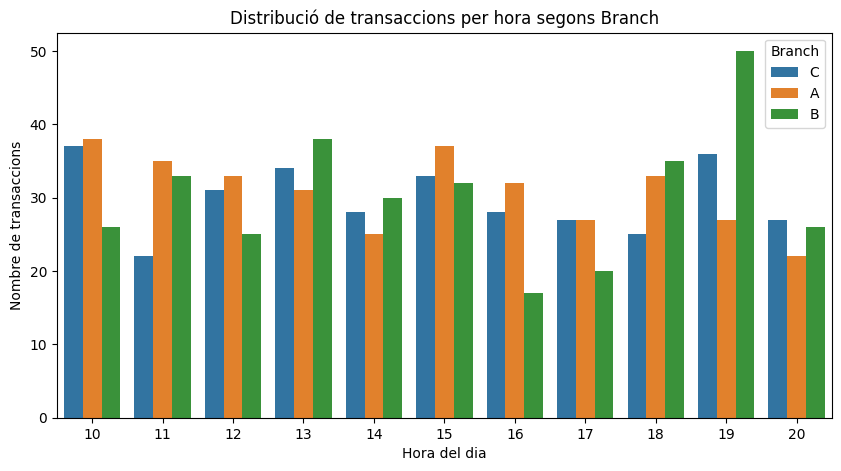

In [1288]:
plt.figure(figsize=(10, 5))
sns.countplot(data=dataset, x=pd.to_datetime(dataset["Time"]).dt.hour, hue="Branch")
plt.title("Distribució de transaccions per hora segons Branch")
plt.xlabel("Hora del dia")
plt.ylabel("Nombre de transaccions")
plt.legend(title="Branch")
plt.show()

A partir de la gràfica anterior, tot i que s'ha analitzat la distribució de transaccions segons l'hora del dia, no s'ha observat una diferenciació suficientment significativa entre les sucursals per considerar aquest atribut com essencial. Els patrons d'activitat horària semblen ser generals i no ofereixen una contribució clara a la predicció del target **Branch**, només destaca a les 19 la sucursal B que té moltes més transaccions respecte a totes les altres hores i sucursals.

A més, aquests patrons podrien estar influenciats per altres atributs com **City** o **Product line**, que mostren diferències més clares entre sucursals. Això podria fer que l'atribut **Time** aporti soroll al model en lloc d'informació útil.

Per tant, l'atribut **Time** es descartarà per evitar complexitat innecessària i overfitting al model, tenint en compte altres atributs temporals com **Month** o **DayOfWeek**, que ja capturen informació més rellevant i generalitzable.

In [1289]:
dataset = dataset.drop("Time", axis=1)

Finalment, es mostrarà en una matriu si hi han valors faltants (nuls) al dataset, per posteriorment fer un tractament, si n'hi ha, al preprocessat de dades.

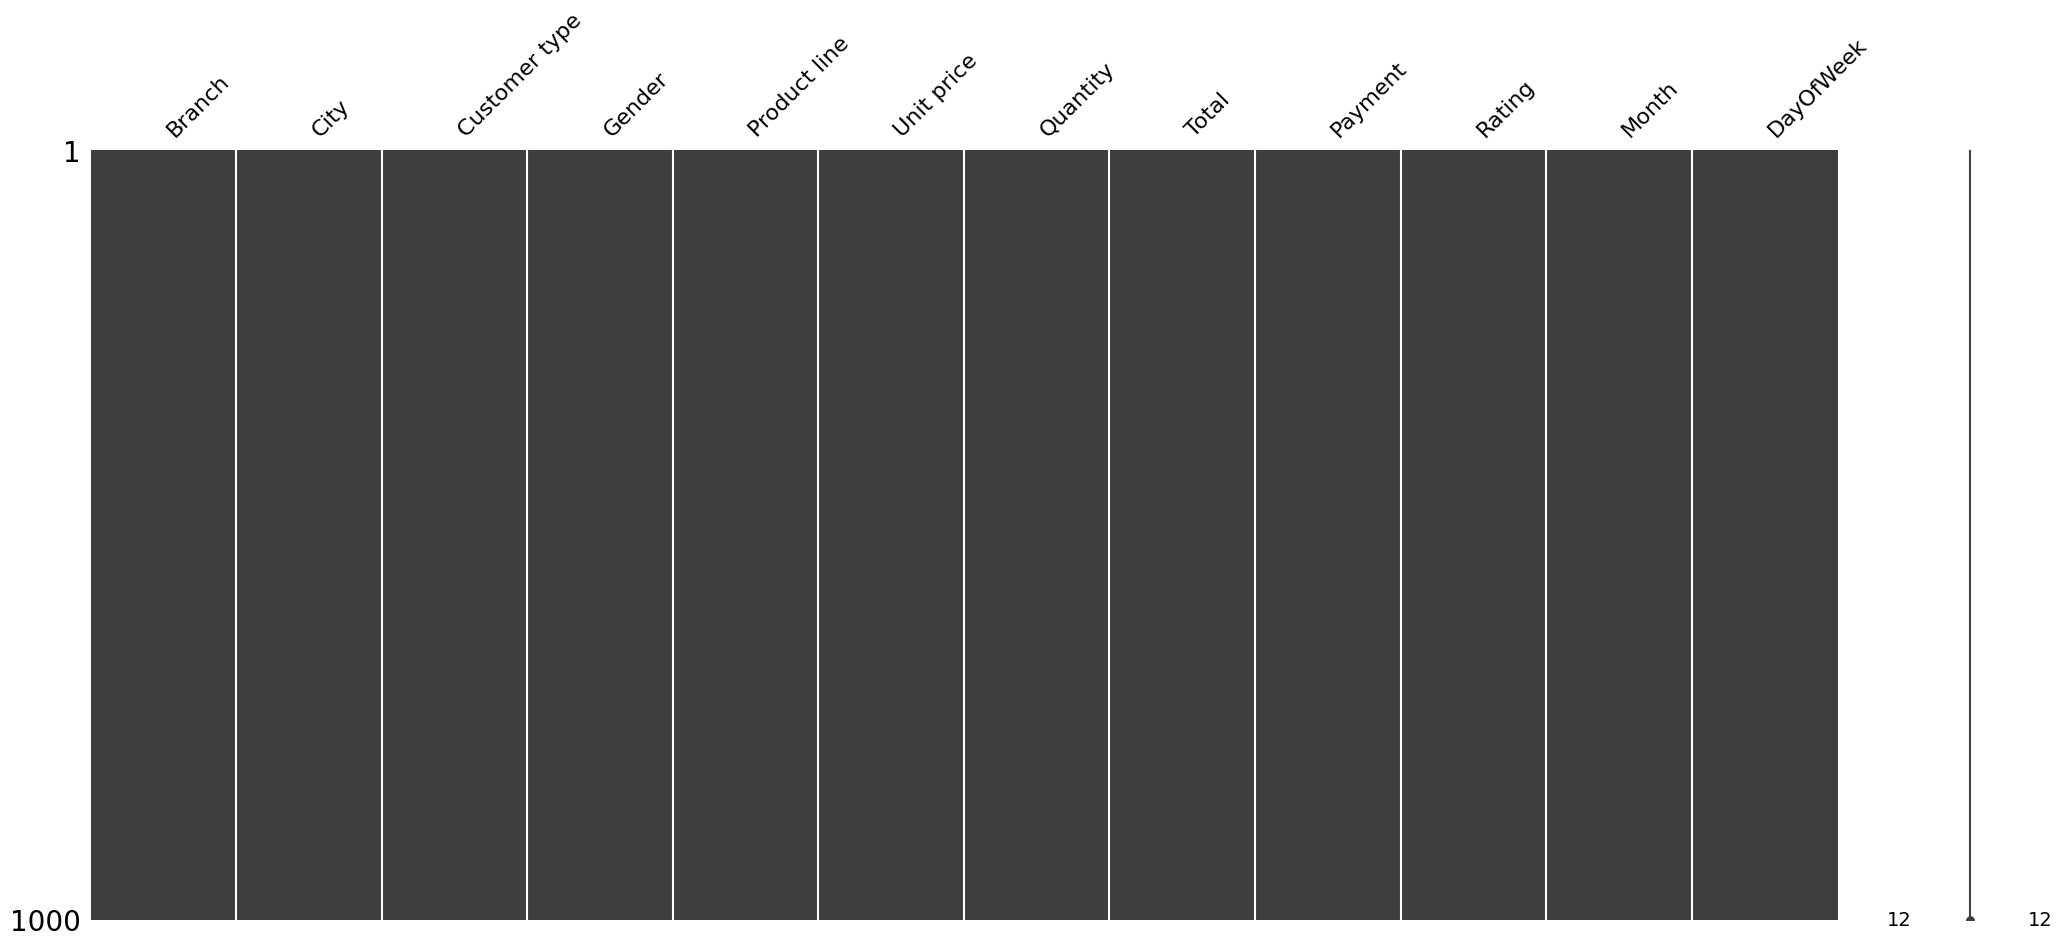

In [1290]:
msno.matrix(dataset)
plt.show()

Com a resultat, es confirma que no hi ha valors nuls en cap columna del dataset. Això indica que no cal fer un tractament de valors faltants al preprocessat.

---

## 2. PREPROCESSAT

En aquest apartat, per tal de garantir un bon preprocessament de dades, es duran a terme diverses accions necessàries per preparar el dataset per a la fase de modelatge.

Primer, es realitzarà la divisió del conjunt de dades en dades d’entrenament i de prova fent una estratificació ens assegura que aquesta distribució es mantingui exactament igual en el conjunt d’entrenament i de prova, evitant possibles desviacions aleatòries durant la divisió. Aquesta divisió és essencial per garantir que el model s’entreni amb una part de les dades i es validi amb una altra part independent, de manera que es pugui mesurar el seu rendiment real en dades mai vistes. A continuació, totes les modificaciones que es faran és farà únicament sobre el conjunt d'entrenament, amb l'objectiu d'evitar el data leakage.

In [1291]:
X = dataset.drop("Branch", axis=1)
y = dataset["Branch"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

Com es va comentar a l'anàlisi de dades, aquest dataset no conté valors nuls, per tant, no fa falta cap preprocessament de valors faltants. Per tant, a continuació, es continuarà amb la codificació de les variables categòriques.

Els models requereixen que les dades estiguin en format numèric, ja que no poden processar variables categòriques directament. Per tant, abans d'entrenar qualsevol model, és necessari convertir aquestes variables categòriques en valors numèrics. A més, com s’ha creats nous atributs categòrics a l’anàlisi de dades, ara és important comprovar quines variables són categòriques actualment, per tal d’aplicar correctament la codificació necessària.

In [1292]:
pd.DataFrame(X_train.dtypes)

,0
City,object
Customer type,object
Gender,object
Product line,object
Unit price,float64
Quantity,int64
Total,float64
Payment,object
Rating,float64
Month,int32


Tenim com a variables categòriques les següents: **City**, **Customer type**, **Gender**, **Product line**, **Payment**, **DayOfWeek** i el target **Branch**.

Per començar, codificarem el target **Branch**. Aquest atribut conté les tres classes a classificar (A, B i C), per tant, es pot utilitzar `LabelEncoder()` com a mètode de codificació, ja que és una eina adequada per convertir classes categòriques en valors numèrics sencers. Això és especialment útil en aquest cas perquè el target és una variable categòrica sense cap ordre implícit entre les classes, ja que ho detecta com etiquetes. La codificació és farà albabèticament, es a dir, s'assignaran així: 
- A -> 0
- B -> 1
- C -> 2

In [1293]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

Pel que fa els atributs binàris, com poden ser **Customer type** i **Gender**. S'utilitzarà `LabelEncoder()`, ja que només tenen dues categories i evitem altres mètodes de codificació que augmenten la dimensionalitat sense cap benefici com pot ser el `OneHotEncoder()`.

In [1294]:
encoderCT = LabelEncoder()
X_train['Customer type'] = encoderCT.fit_transform(X_train['Customer type'])
X_test['Customer type'] = encoderCT.transform(X_test['Customer type'])

encoderG = LabelEncoder()
X_train['Gender'] = encoderG.fit_transform(X_train['Gender'])
X_test['Gender'] = encoderG.transform(X_test['Gender'])

Pels atributs **City**, **Product line** i **Payment**, al tenir més de dues categories no és pot fer la codificació amb `LabelEncoder()`, ja que pot introduir un ordre o jerarquia inexistent a les seves categories. Per tant, la millor opció es utilitzar `OneHotEncoder()`per tal de garantir que els models interpretin correctament les dades.

In [1295]:
encoderC = OneHotEncoder(sparse_output=False, drop=None) # Encoder de City
encoderPL = OneHotEncoder(sparse_output=False, drop=None) # Encoder de Product Line
encoderP = OneHotEncoder(sparse_output=False, drop=None) # Encoder de Payment

# Codificar City
city_encoded_train = encoderC.fit_transform(X_train[["City"]])
city_encoded_test = encoderC.transform(X_test[["City"]])
city_columns = encoderC.get_feature_names_out(["City"])
city_encoded_train = pd.DataFrame(city_encoded_train, columns=city_columns, index=X_train.index)
city_encoded_test = pd.DataFrame(city_encoded_test, columns=city_columns, index=X_test.index)

# Codificar Product line
product_line_encoded_train = encoderPL.fit_transform(X_train[["Product line"]])
product_line_encoded_test = encoderPL.transform(X_test[["Product line"]])
product_line_columns = encoderPL.get_feature_names_out(["Product line"])
product_line_encoded_train = pd.DataFrame(product_line_encoded_train, columns=product_line_columns, index=X_train.index)
product_line_encoded_test = pd.DataFrame(product_line_encoded_test, columns=product_line_columns, index=X_test.index)

# Codificar Payment
payment_encoded_train = encoderP.fit_transform(X_train[["Payment"]])
payment_encoded_test = encoderP.transform(X_test[["Payment"]])
payment_columns = encoderP.get_feature_names_out(["Payment"])
payment_encoded_train = pd.DataFrame(payment_encoded_train, columns=payment_columns, index=X_train.index)
payment_encoded_test = pd.DataFrame(payment_encoded_test, columns=payment_columns, index=X_test.index)

# Afegir les noves columnes codificades al conjunt de prova i entrenament
X_train = pd.concat([X_train.drop(columns=["City", "Product line", "Payment"]), city_encoded_train, product_line_encoded_train, payment_encoded_train], axis=1)
X_test = pd.concat([X_test.drop(columns=["City", "Product line", "Payment"]), city_encoded_test, product_line_encoded_test, payment_encoded_test], axis=1)

Per la codificació de l'atribut **DayOfWeek**, el codificarem de manera que es pugui capturar la naturalesa cíclica que té aquest atribut. Els dies de la setmana tenen una estructura circular com per exemple, diumenge segueix a dilluns en un cicle continu. Per representar aquesta característica de manera efectiva, s'ha utilitzat un encoding basat en les funcions trigonomètriques sin i cos. Aquesta combinació del sin i cos permet representar una posició dins del cercle unitari.

Gràcies a aquest enfocament permet al model comprendre millor les relacions entre els dies consecutius i oposats en el cicle setmanal, beneficiant a que un model pugui augmentar la capacitat d'extreure patrons d'aquest atribut.

In [1296]:
day_num = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6}
X_train["DayOfWeek"] = X_train["DayOfWeek"].map(day_num)
X_test["DayOfWeek"] = X_test["DayOfWeek"].map(day_num)

X_train['DayOfWeek_sin'] = np.sin(2 * np.pi * X_train["DayOfWeek"] / 7)
X_train['DayOfWeek_cos'] = np.cos(2 * np.pi * X_train["DayOfWeek"] / 7)
X_test['DayOfWeek_sin'] = np.sin(2 * np.pi * X_test["DayOfWeek"] / 7)
X_test['DayOfWeek_cos'] = np.cos(2 * np.pi * X_test["DayOfWeek"] / 7)

X_train = X_train.drop("DayOfWeek", axis=1)
X_test = X_test.drop("DayOfWeek", axis=1)

Podem veure la representació del cercle unitari a la següent cel·la, on es mostra com quedarà distribuit amb aquest mètode l'atribut **DayOfWeek**.

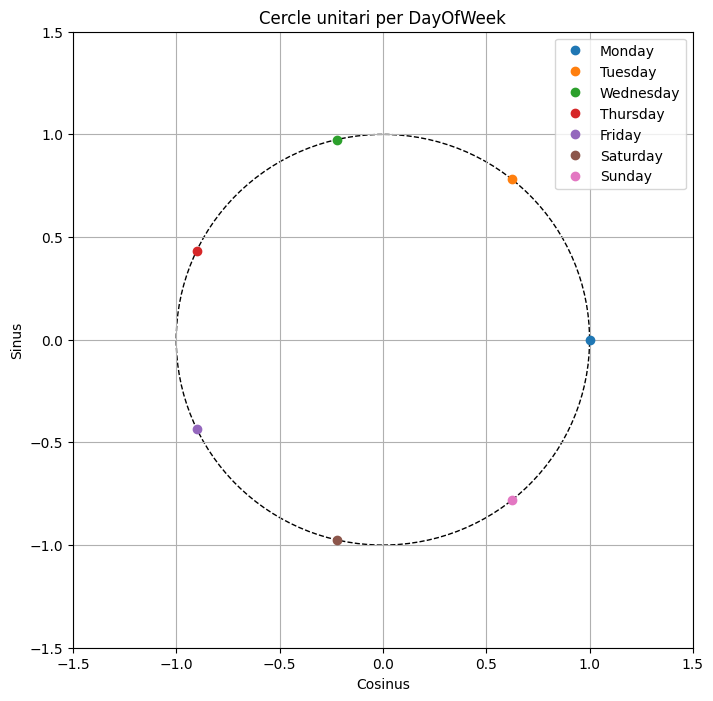

In [1297]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
angles = np.linspace(0, 2 * np.pi, len(days), endpoint=False)
sin_values = np.sin(angles)
cos_values = np.cos(angles)

plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, fill=False, linestyle='--')
plt.gca().add_artist(circle)

for i, day in enumerate(days):
    plt.plot(cos_values[i], sin_values[i], 'o', label=day)

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.title("Cercle unitari per DayOfWeek")
plt.xlabel("Cosinus")
plt.ylabel("Sinus")
plt.legend(loc="upper right")
plt.grid()
plt.show()

Com a últim atribut a considerar per a la normalització, **Month**, observem que ja està codificat numèricament. No obstant, aquest atribut té la particularitat de les dades temporals, que segueix una naturalesa cíclica. En aquest cas, al tenir només tres mesos (Gener, Febrer i Març), no és significatiu utilitzar una codificació cíclica. Tot i això, és important evitar que el model interpreti un ordre ordinal entre els mesos. Per aquest motiu, s’utilitzarà una codificació One-Hot, que permet tractar cada mes com una categoria independent.

In [1298]:
encoderM = OneHotEncoder(sparse_output=False, drop=None)

month_encoded_train = encoderM.fit_transform(X_train[["Month"]])
month_encoded_test = encoderM.transform(X_test[["Month"]])
month_columns = encoderM.get_feature_names_out(["Month"])
month_encoded_train = pd.DataFrame(month_encoded_train, columns=month_columns, index=X_train.index)
month_encoded_test = pd.DataFrame(month_encoded_test, columns=month_columns, index=X_test.index)

X_train = pd.concat([X_train.drop(columns=["Month"]), month_encoded_train], axis=1)
X_test = pd.concat([X_test.drop(columns=["Month"]), month_encoded_test], axis=1)

Ara que ja tenim totes les dades en format numèric, el següent pas es normalitzar les dades. L’objectiu d’aquesta normalització és garantir que totes les variables tinguin una escala similar. Això és especialment rellevant quan es treballa amb models que utilitzen distàncies o càlculs geomètrics, es a dir, models que sensibles a l'escala com la regressió logística o KNN, ja que atributs amb escales molt diferents poden influir desproporcionadament en els resultats.

Per la normalització tindrem en compte només els atributs continus, que son: **Unit price**, **Quantity**, **Total** i **Rating**. Això es degut a que aquests atributs contenen rangs més amplis que podrien impactar en aquests models sensibles a l'escala. La normalització que es farà servir és `StandardScaler()`, ja que aquest mètode ajusta els valors perquè tinguin una mitjana de 0 i una desviació estàndard de 1. L’ús d'aquesta normalització ajuda a millorar la convergència dels models basats en optimització com els mencionats anteriorment, i assegura que cap atribut domini als altres degut a diferències en l’escala.

In [1299]:
atributsContinus = ["Unit price", "Quantity", "Total", "Rating"]

scaler = StandardScaler()
X_train[atributsContinus] = scaler.fit_transform(X_train[atributsContinus])
X_test[atributsContinus] = scaler.transform(X_test[atributsContinus])

Com a últim apartat del preprocessament, seleccionarem els atributs per al nostre model amb l’objectiu de millorar el rendiment, reduir la complexitat i evitar redundàncies que podrien afectar negativament als resultats. A continuació, es pot veure la matriu de correlació entre tots els atributs.

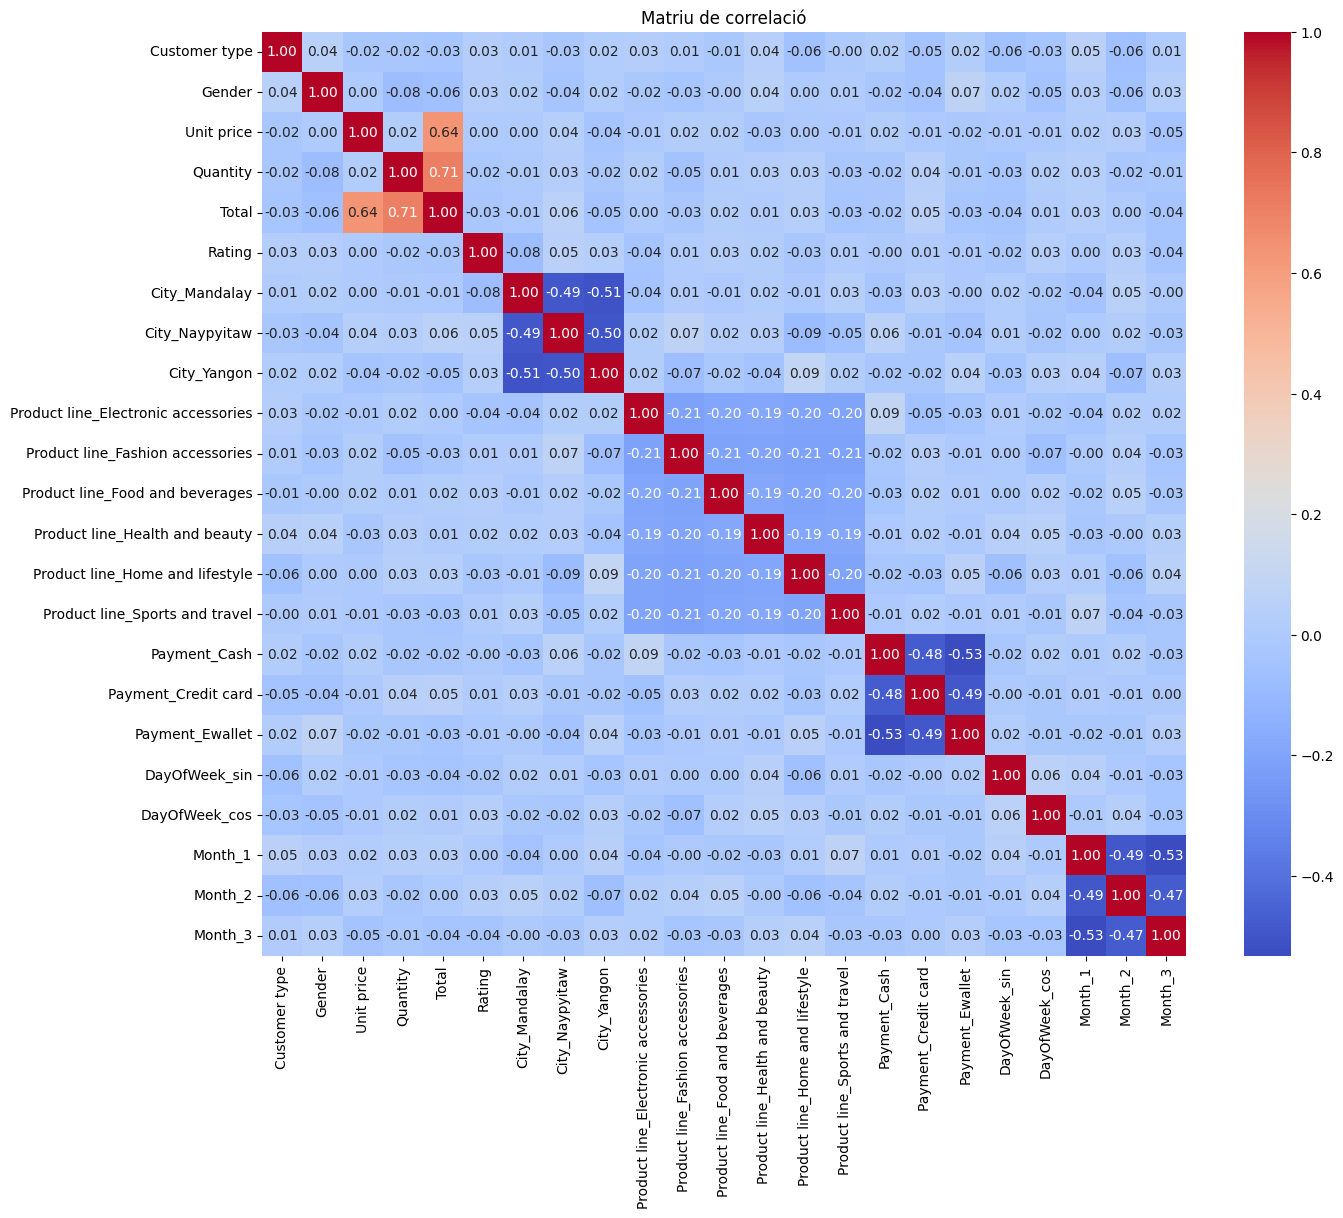

In [1300]:
matriuCorrelacio = X_train.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(matriuCorrelacio, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriu de correlació")
plt.show()

Com a primera observació de la matriu anterior, podem veure una alta correlació entre els atributs **Total**, **Unit price** i **Quantity**. Això significa que, incloure tots tres atributs al model podria introduir informació redundant, la qual cosa podria augmentar la dimensionalitat del model sense aportar un benefici significatiu. Per tant, amb aquesta informació el que es farà és mantenir l'atribut **Total**, ja que aquest engloba tota la informació dels altres dos atributs de manera més completa.

In [1301]:
X_train = X_train.drop(columns=["Unit price", "Quantity"])
X_test = X_test.drop(columns=["Unit price", "Quantity"])

Pel que fa els altres atributs, podem trobar unes correlacions moderades als atributs **City**, **Payment** i **Month**. Això es deu al `OneHotEncoder()`, ja que quan una de les seves categories és 1, les altres per força son 0, provocant aquestes correlacions negatives.

Finalment, es presenta el conjunt de dades d’entrenament després d’haver completat tot el procés de preprocessament. A continuació, es farà la selecció de la millor mètrica per tal d’avaluar adequadament el rendiment dels models que es construiran en els següents apartats.

In [1302]:
X_train.head()

,Customer type,Gender,Total,Rating,City_Mandalay,City_Naypyitaw,City_Yangon,Product line_Electronic accessories,Product line_Fashion accessories,Product line_Food and beverages,...,Product line_Home and lifestyle,Product line_Sports and travel,Payment_Cash,Payment_Credit card,Payment_Ewallet,DayOfWeek_sin,DayOfWeek_cos,Month_1,Month_2,Month_3
884,0,0,-0.616734,0.356013,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.781831,0.623490,0.0,0.0,1.0
572,0,1,-1.025750,0.761478,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,-0.781831,0.623490,0.0,0.0,1.0
777,1,1,-0.929785,1.514485,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.433884,-0.900969,1.0,0.0,0.0
46,0,1,0.850419,0.819402,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.974928,-0.222521,0.0,1.0,0.0
178,1,1,0.564573,-1.497542,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,-0.974928,-0.222521,0.0,0.0,1.0


---

## 3. SELECCIÓ DE MÈTRIQUES D'EVALUACIÓ

En aquest apartat, es decidirà quina es la millor mètrica per evaluar el rendiment dels models que posteriorment s'evaluaran a l'apartat de validació per trobar millor.

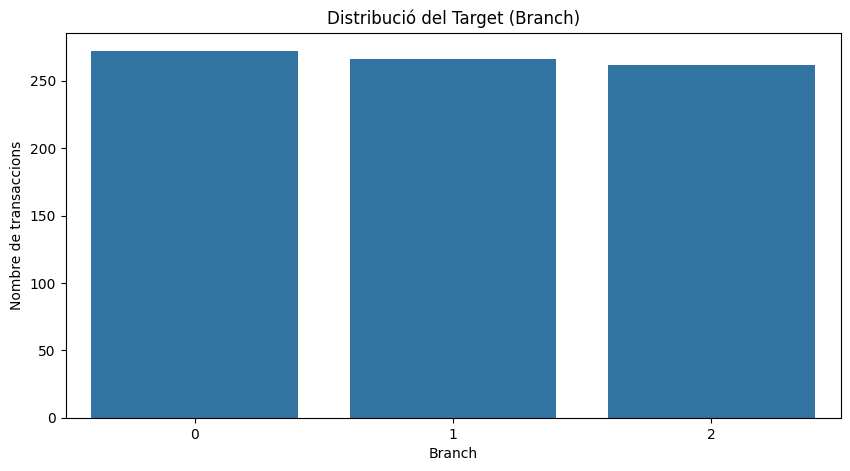

In [1303]:
plt.figure(figsize=(10, 5))
sns.countplot(data=pd.DataFrame(y_train, columns=["Branch"]), x="Branch")
plt.title("Distribució del Target (Branch)")
plt.xlabel("Branch")
plt.ylabel("Nombre de transaccions")
plt.show()

In [1304]:
percentatgeTarget = pd.Series(y_train).value_counts(normalize=True) * 100
percentatgeTarget = pd.DataFrame(percentatgeTarget.sort_index())
percentatgeTarget

,proportion
0,34.00
1,33.25
2,32.75


Podem veure a la gràfica anterior que tenim el conjunt del target bastant equilibrat a les tres classes, amb una diferència de 1.25% entre la classe més alta respecte a la més baixa. Per aquest motiu, s'escollirà com a mètrica d'avaluació el **Accuracy**, ja que en aquest cas cap classe domina sobre les altres, i per tant, aquesta mètrica proporciona una avaluació justa del rendiment del model. A més, totes les classes del target tenen la mateixa rellevància, es a dir, l’objectiu és optimitzar la gestió d’inventaris de manera equitativa a les tres ubicacions. Per tant, no cal donar més pes a cap classe en particular.

A més de la mètrica d'avaluació Accuracy s'utilitzarà la gràfica ROC com a eina per mesurar la relació entre el Recall i el False Positive Rate, això amb l'objectiu d'avaluar el rendiment global del model. Una mètrica adicional associada a la gràfica ROC és l’AUC, que permet resumir el rendiment del model en un únic valor. L’AUC mesura la capacitat del model per distingir entre les classes, on un valor proper a 1 indica un excel·lent rendiment, mentre que un valor proper a 0.5 suggereix que el model no té capacitat de discriminació.

Com a ajuda per avaluar el model, també s’utilitzarà la matriu de confusió per visualitzar detalladament com de bé ha predit el model cada classe. Aquesta eina permet identificar directament el nombre de vertaders positius, falsos positius, vertaders negatius i falsos negatius per a cada classe, facilitant l’anàlisi dels errors específics que pugui cometre el model a cada classe.

A la següent cel·la es pot veure la funció per crear la gràfica ROC-AUC que s'utilitzarà més endavant per avaluar el model.

In [1305]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def crear_ROC_AUC(y_true, y_pred_prob, classes):
    plt.figure(figsize=(10, 7))
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true == class_label, y_pred_prob[:, i])
        auc = roc_auc_score(y_true == class_label, y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f"Classe {class_label} (AUC = {auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label="Model Aleatori")
    plt.title("Gràfica ROC-AUC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

---

## 4. SELECCIÓ DE MODELS

---

## 5. CONCLUSIÓ